In [108]:
import os
from os import path
import re
import json
import time
import math

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy

DIRETORIO_PDF = 'BauruPDF/'
DIRETORIO_TXT = 'BauruTXT/'
DIRETORIO_DOC = 'BauruDOC/'
DIRETORIO_PAR = 'BauruPAR/'
DIRETORIO_JSON = 'BauruJSON/'

nlp_exclude_list = ['parser',
                    'ner',
                    'entity_linker',
                    'entity_ruler',
                    'textcat',
                    'textcat_multilabel',
                    'lemmatizer',
                    'trainable_lemmatizer',
                    'morphologizer',
                    'attribute_ruler',
                    'senter',
                    'sentencizer',
                    'tok2vec',
                    'transformer']
global_nlp = spacy.load('pt_core_news_lg', exclude = nlp_exclude_list)

In [342]:
def similaridade_cosseno(a, b):
    """
    Calcula a similaridade de cosseno entre dois dicts.
    Supõe-se que as chaves são iguais, compondo "vetores" a e b em um mesmo espaço.
    Como se trata de sacos de palavras, os vetores terão apenas valores inteiros positivos,
    logo a similaridade não poderão assumir similaridades negativas.
    
    :param a dict: "vetor" a
    :param b dict: "vetor" b
    
    :returns: valor no intervalo [0, 1] similaridade cosseno entre os "vetores" a e b.
    """
    
    assert type(a) == dict
    assert type(b) == dict
    assert a.keys() == b.keys()
    
    produto_escalar  = 0
    soma_a = 0
    soma_b = 0
    
    for k in a:
        produto_escalar  += a[k] * b[k]
        soma_a           += math.pow(a[k], 2)
        soma_b           += math.pow(b[k], 2)

    magnitude = math.sqrt(soma_a) * math.sqrt(soma_b)
    
    if abs(magnitude) < 1e-3:
        similaridade = 0
    else:
        similaridade = produto_escalar / magnitude
    
    return similaridade

def atualiza_chaves(d, ks):
    """
    Atualiza as chaves do dict d para conter também as chaves ks.
    
    :param d dict: dict a ser atualizado
    :param ks dict_keys: chaves a serem adicionadas em d
    
    :returns: dict d
    """
    
    for k in ks:
        if k not in d:
            d[k] = 0

    return d

def token_valido(token):
    """
    Verifica se um token é valido para ser incluído no saco de palavras
    
    :param token spacy.tokens.Token: token a ser verificado
    
    :returns: bool se é válido ou não
    """
    
    assert type(token) == spacy.tokens.Token
    
    return not (token.is_stop
               or token.is_space
               or token.is_punct
               or token.is_currency
               or token.is_quote
               or token.is_bracket
               or token.like_num
               or token.is_oov)

def monta_saco_palavras(doc, saco = None):
    """
    Monta/atualiza o saco de palavras de um doc com os tokens válidos da função token_valido.
    
    :param doc spacy.tokens.Doc: Doc a ser utilizado no saco de palavras.
    :keyword saco dict: saco de palavras a ser atualizado, ou criado, caso não especificado
    
    :returns: saco de palavras criado, ou atualizado
    """
    
    if saco == None:
        saco = dict()
    
    for token in doc:
        if token_valido(token):
            chave = token.norm_
            if chave not in saco:
                saco[chave] = 0
            saco[chave] += 1
        else:
            pass
    return saco

# def inicializa_novo_saco_com_template(template):
#     """
#     Inicializa um novo saco vazio a partir de um template.
#     Ou seja, inicializa um saco vazio com as chaves dadas por um template.
    
#     :param template dict: template do saco de palavras
    
#     :returns: novo saco de palavras
#     """
#     assert type(template) == dict
    
#     saco = {}
#     for chave in template:
#         saco[chave] = 0
#     return saco

In [345]:
def calcula_similaridade_doc(doc, saco_alvo_template):
    """
    Calcula a similaridade do saco de um Doc com outro saco previamente gerado.
    
    :param doc spacy.tokens.Doc: Doc a ser analisado.
    :param saco_alvo_template dict: saco a ser comparado.
    
    :returns: similaridade dos sacos gerados
    """
    
    saco_alvo = saco_alvo_template.copy()
    saco_doc = {}
    
    atualiza_chaves(saco_doc, saco_alvo.keys())
    monta_saco_palavras(doc, saco_doc)
    atualiza_chaves(saco_alvo, saco_doc.keys())
    
    similaridade = similaridade_cosseno(saco_alvo, saco_doc)
    
    return similaridade

def calcula_similaridade_entre_docs(doc_a, doc_b):
    saco_a = monta_saco_palavras(doc_a)
    similaridade = calcula_similaridade_doc(doc_b, saco_a)
    
    return similaridade

In [350]:
info_licitacoes = []
for licitacao_filename in os.listdir(DIRETORIO_JSON):
    if path.splitext(licitacao_filename)[1] != '.json':
        continue
    
    print(licitacao_filename, end = ': ')
    info_licitacao = {}
    
    with open(path.join(DIRETORIO_JSON, licitacao_filename), 'r') as licitacao_arquivo:
        licitacao = json.load(licitacao_arquivo)

    info_licitacao['identificador'] = licitacao['identificador']
    
    especificacao_doc = None
    saco_especificacao = None
    if 'especificacao' in licitacao:
        especificacao_doc = nlp(licitacao['especificacao'])
        saco_especificacao = monta_saco_palavras(especificacao_doc)
    else:
        info_licitacao['resultado'] = 'sem especificacao'
        print('sem especificacao')
        info_licitacoes.append(info_licitacao)
        continue
    
    publicacoes_doc = None
    if 'publicacoes' in licitacao:
        publicacoes_doc = []
        print('com', str(len(licitacao['publicacoes'])), 'publicacoes.')
        for publicacao in licitacao['publicacoes']:
            publicacao_doc = nlp(publicacao['conteudo'])
            
            info_licitacao['titulo_pub'] = publicacao['titulo']
            info_licitacao['dia_pub'] = publicacao['dia']
            info_licitacao['mes_pub'] = publicacao['mes']
            info_licitacao['ano_pub'] = publicacao['ano']
            
            info_licitacao['similaridade_esp_pub'] = calcula_similaridade_doc(publicacao_doc, saco_especificacao)
            info_licitacao['resultado'] = 'ok'
            info_licitacoes.append(info_licitacao)
    else:
        info_licitacao['resultado'] = 'sem publicacao'
        info_licitacoes.append(info_licitacao)
        print('sem publicacoes')
        continue


In [261]:
df_orig = pd.DataFrame(info_licitacoes)

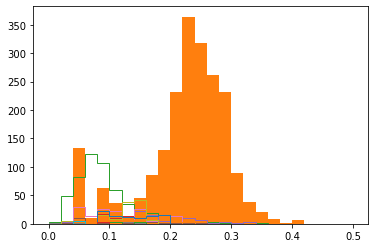

In [260]:
df = df_orig[df_orig['similaridade_esp_pub'] >= 0]
#df_abertura = df[df['titulo_pub'] == 'Abertura']
#df_homolog = df[df['titulo_pub'] == 'Homologação']

titulos = df['titulo_pub'].unique()
df_similaridades = pd.DataFrame(data = {'titulo': df['titulo_pub'], 'similaridade': df['similaridade_esp_pub']})

for titulo in titulos:
    if titulo == 'Abertura':# or titulo == 'Homologação':
        plt.hist(df_similaridades[df_similaridades['titulo'] == titulo]['similaridade'],
             bins = 25, range = (0.0, 0.5), histtype = 'bar', label = titulo)
        continue
    plt.hist(df_similaridades[df_similaridades['titulo'] == titulo]['similaridade'],
             bins = 25, range = (0.0, 0.5), histtype = 'step', label = titulo)

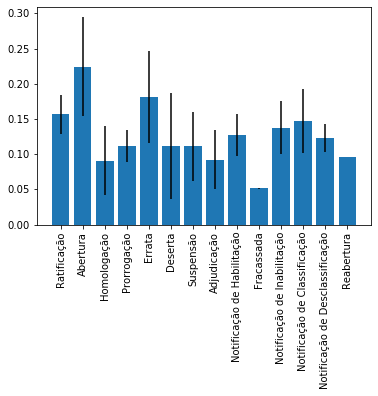

In [251]:
t = []
m = []
s = []
for titulo in titulos:
    df_temp = df_similaridades[df_similaridades['titulo'] == titulo]
    t.append(titulo)
    m.append(df_temp['similaridade'].mean())
    s.append(df_temp['similaridade'].std())

plt.bar(t, m, yerr = s)

plt.xticks(rotation = 90)
pass

In [351]:
df = df_orig
ids = df[df['titulo_pub'] == 'Errata'].sample(10)['identificador'].values
for i in ids:
    with open(path.join(DIRETORIO_JSON, i + '.json'), 'r') as arquivo:
        licitacao = json.load(arquivo)
    print(licitacao['especificacao'])
    print(licitacao['publicacoes'])
    

In [367]:
#df = df_orig.copy()
#sample = df.sample(10)

for licitacao_filename in sample['identificador']: #os.listdir(DIRETORIO_JSON):
    #if path.splitext(licitacao_filename)[1] != '.json':
    #    continue
    
    with open(path.join(DIRETORIO_JSON, licitacao_filename + '.json'), 'r') as licitacao_arquivo:
        licitacao = json.load(licitacao_arquivo)

    info_licitacao['identificador'] = licitacao['identificador']
    
    publicacoes_doc = None
    if 'publicacoes' in licitacao:
        publicacoes_doc = {}
        for publicacao in licitacao['publicacoes']:
            chave = publicacao['titulo'] + publicacao['ano'] + publicacao['mes'] + publicacao['dia']
            publicacoes_doc[chave] = nlp(publicacao['conteudo'])
        
        if len(publicacoes_doc) > 1:
            num_publicacoes = len(publicacoes_doc)
            matriz_similaridades = np.zeros((num_publicacoes, num_publicacoes))
            
            l_temp = licitacao['publicacoes'][0]
            similaridade_max = 0.0
            chave_max_a = l_temp['titulo'] + l_temp['ano'] + l_temp['mes'] + l_temp['dia']
            chave_max_b = l_temp['titulo'] + l_temp['ano'] + l_temp['mes'] + l_temp['dia']
            similaridade_min = 1.0
            chave_min_a = l_temp['titulo'] + l_temp['ano'] + l_temp['mes'] + l_temp['dia']
            chave_min_b = l_temp['titulo'] + l_temp['ano'] + l_temp['mes'] + l_temp['dia']
            
            
            for nA, publicacao_a in enumerate(publicacoes_doc):
                saco_a_template = monta_saco_palavras(publicacoes_doc[publicacao_a])
                
                for nB, publicacao_b in enumerate(publicacoes_doc):
                    if nA <= nB:
                        continue
                    sim = calcula_similaridade_doc(publicacoes_doc[publicacao_b], saco_a_template)
                    
                    if sim > similaridade_max:
                        similaridade_max = sim
                        chave_max_a = publicacao_a
                        chave_max_b = publicacao_b
                        
                    if sim < similaridade_min:
                        similaridade_min = sim
                        chave_min_a = publicacao_a
                        chave_min_b = publicacao_b
                    
                    matriz_similaridades[nA, nB] = sim
                    
            print('##############################')
            print(licitacao_filename)
            #print('max', similaridade_max, chave_max_a, chave_max_b)
            print(publicacoes_doc[chave_max_a])
            print('--------------------------------')
            print(publicacoes_doc[chave_max_b])
            #print('min', similaridade_min, chave_min_a, chave_min_b)
            print('===================================')
#             print(publicacoes_doc[chave_min_a])
#             print('--------------------------------')
#             print(publicacoes_doc[chave_min_b])
            print(matriz_similaridades)
    else:
        pass


##############################
4973
 NOTIFICAÇÃO DE ADJUDICAÇÃO E HOMOLOGAÇÃO - 
Notificamos aos interessados no processo licitatório epigrafado que o julgamento e a classificação havida foi devidamente Adjudicada e Homologada em 12/11/2018 pelo Sr. Prefeito Municipal a empresa: VITIVER SISTEMAS DE SEGURANÇA ELETRÔNICA LTDA – ME, conforme abaixo:
LOTE 01 – SERVIÇOS DE INSTALAÇÃO DE ALARME COM CÂMARA E MONITORAMENTO - AMPLA PARTICIPAÇÃO
Item	Qtd	Und	Especificações Mínimas	P. Unit R$	P. Total R$
01	865	Peça	Serviço de instalação de câmeras com Infravermelho CFTV 2 megapixels (conforme memorial descritivo anexo I do Edital n. 355/2018). 	90,00	77.850,00
02	190	Peça	Serviço de instalação de fonte de alimentação para câmera 12 V 10 A (conforme memorial descritivo anexo I do Edital n. 355/2018). 	60,00	11.400,00
03	190	Peça	Serviço de instalação de gravador FULL HD - 08 Canais com saída de alarme para alertas e análise de imagens (conforme memorial descritivo anexo I do Edital n. 355/2018).	

##############################
7182
 NOTIFICAÇÃO DE ABERTURA - ÓRGÃO: PREFEITURA MUNICIPAL DE BAURU - SECRETARIA MUNICIPAL DE SAÚDE
Processo: 147.4702021 – Modalidade: Pregão Eletrônico SMS n° 26/2022 – EXCLUSIVA PARA PARTICIPAÇÃO DE ME’S EPP’S - por meio da INTERNET – Tipo Menor Preço por Item – Objeto: aquisição de atomizador/nebulizador, lanternas, carro de transporte manual, big bags, tela mosquiteiro, caixa plástica, frasco conta gota, galão térmico, focinheiras e bolsa em lona para ferramentas para o município. A Data do Recebimento das Propostas será até dia 11/05/2022 às 09h - A abertura da Sessão dar-se-á no dia 11/05/2022 às 09h – Pregoeira: Mari Yasuoka. O Edital completo e informações poderão ser obtidos na Divisão de Compras e Licitações, Rua Gérson França, 7-49, 1º andar, Centro, CEP: 17015-200 – Bauru/SP, fone (14) 3104-1463/1465, ou pelo site www.bauru.sp.gov.br ou www.bec.sp.gov.br, OC 820900801002022OC00189 e 820900801002022OC00190 , onde se realizará a sessão de preg

##############################
5948
 NOTIFICAÇÃO DE ABERTURA DE LICITAÇÃO - 
Edital nº 070/20 – Processo nº 173.840/19 – Modalidade: Pregão Eletrônico nº 011/20 – Do Tipo Menor Preço por Lote – DIFERENCIADA NO MODO COTA RESERVADA PARA ME E EPP- Objeto: AQUISIÇÃO DE MICROCOMPUTADORES E NOTEBOOKS CONFORME ESPECIFICAÇÕES DO ANEXO I e III DO EDITAL. – Interessada: Secretaria Municipal do Bem Estar Social. Data do Recebimento das propostas: até às 9h do dia 02/04/2020. Abertura da Sessão: dia 02/04/2020 às 9h. Informações e edital na Secretaria da Administração/Divisão de Licitações, sito na Praça das Cerejeiras, 1-59, Vila Noemy – 2º andar, sala 10 - CEP. 17.014-900 – Bauru/SP, no horário das 08h às 12h e das 13h às 17h e telefone (14) 3235-1337 ou através de download gratuito no site www.bauru.sp.gov.br, ou através do site www.bec.sp.gov.br, Oferta de Compra 820900801002020OC00092 onde se realizará a sessão de pregão eletrônico, com os licitantes devidamente credenciados. 
---------------

In [192]:
#plt.scatter(range(df_abertura['similaridade_esp_pub'].size), df_abertura['similaridade_esp_pub'])
#plt.scatter(range(df_homolog['similaridade_esp_pub'].size), df_homolog['similaridade_esp_pub'])

(array([14.,  6., 26., 23., 26., 32., 34., 41., 43., 39., 40., 32., 28.,
        23., 12., 15.,  9.,  8., 12.,  5., 10.,  4.,  8.,  8.,  1.,  5.,
         6.,  3.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,  2.,  0.,  1.,
         1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01778984, 0.02445634, 0.03112284, 0.03778934, 0.04445584,
        0.05112234, 0.05778884, 0.06445534, 0.07112184, 0.07778835,
        0.08445485, 0.09112135, 0.09778785, 0.10445435, 0.11112085,
        0.11778735, 0.12445385, 0.13112035, 0.13778685, 0.14445335,
        0.15111985, 0.15778635, 0.16445285, 0.17111935, 0.17778585,
        0.18445236, 0.19111886, 0.19778536, 0.20445186, 0.21111836,
        0.21778486, 0.22445136, 0.23111786, 0.23778436, 0.24445086,
        0.25111736, 0.25778386, 0.26445036, 0.27111686, 0.27778336,
        0.28444986, 0.29111636, 0.29778287, 0.30444937, 0.31111587,
        0.31778237, 0.32444887, 0.33111537, 0.33778187, 0.34444837,
        0.35111487]),
 <a list of 1 

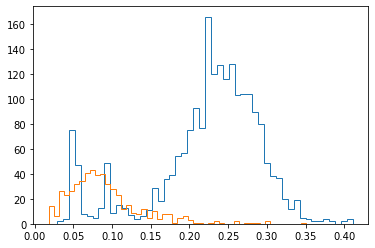

In [193]:
#plt.hist(df_abertura['similaridade_esp_pub'], bins = 50, histtype = 'step', label = 'Abertura')
#plt.hist(df_homolog['similaridade_esp_pub'], bins = 50, histtype = 'step', label = 'Homologação')

In [196]:
titulos_pub = df['titulo_pub'].unique()

print(titulos_pub)

for titulo in titulos_pub:
    plt.hist(df_abertura['similaridade_esp_pub'], bins = 50, histtype = 'step', label = titulo)


['Ratificação' 'Abertura' 'Homologação' 'Prorrogação' 'Errata' 'Deserta'
 'Suspensão' 'Adjudicação' 'Notificação de Habilitação' 'Fracassada'
 'Notificação de Inabilitação' 'Notificação de Classificação'
 'Notificação de Desclassificação' 'Reabertura']


TypeError: hist() missing 1 required positional argument: 'x'

<BarContainer object of 14 artists>

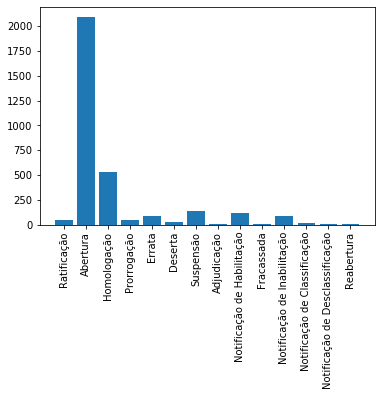

In [184]:
titulos_pub = df['titulo_pub'].unique()
titulos = []
nums = []

for titulo in titulos_pub:
    titulos.append(titulo)
    nums.append(sum(df['titulo_pub'] == titulo))

titulos = titulos
nums = nums

plt.xticks(rotation = 90)
plt.bar(titulos, nums)

<BarContainer object of 6 artists>

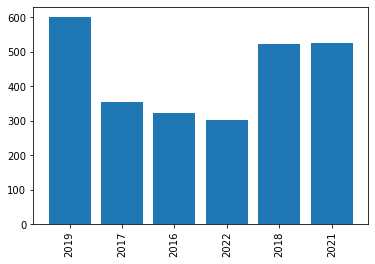

In [180]:
anos_pub = df['ano_pub'].unique()
anos = []
nums = []

for ano in anos_pub:
    anos.append(ano)
    nums.append(sum(df['ano_pub'] == ano))

anos = anos[1:]
nums = nums[1:]
    
plt.xticks(rotation = 90)
plt.bar(anos, nums)

974 0.3934447376823168

CONTRATAÇÃO DE SERVIÇOS TÉCNICOS ESPECIALIZADOS PARA EXECUÇÃO DE ENSAIOS DE LABORATÓRIO E CONTROLE TECNOLÓGICO DE SOLOS, ASFALTO E CONCRETO PELO SISTEMA DE REGISTRO DE PREÇOS CONFORME ANEXOS I e III DO EDITAL.

NOTIFICAÇÃO DE RESULTADO DE LICITAÇÃO - Edital nº 107/2022 – Processo nº 179.566/2021 
– Modalidade: Pregão Eletrônico nº 042/2022 – do tipo MENOR PREÇO POR LOTE – AMPLA 
PARTICIPAÇÃO - OBJETO: CONTRATAÇÃO DE SERVIÇOS TÉCNICOS ESPECIALIZADOS 
PARA EXECUÇÃO DE ENSAIOS DE LABORATÓRIO E CONTROLE TECNOLÓGICO DE 
SOLOS, ASFALTO E CONCRETO PELO SISTEMA DE REGISTRO DE PREÇOS CONFORME 
ANEXOS I e III DO EDITAL. Interessada: Secretaria de Obras. Notificamos aos interessados no 
processo licitatório epigrafado, que certame resultado FRACASSADO.
Bauru, 03/06/2022 – Talita Cristina Pereira Vicente – Diretora da Divisão de Licitação.



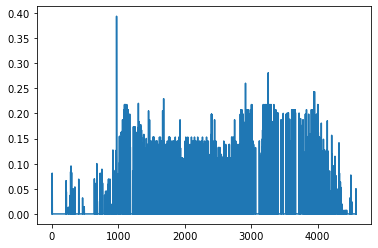

In [55]:
saco_alvo_template = monta_saco_palavras(doc_alvo)
similaridades = []

for paragrafo in doc_universo:
    similaridades.append(calcula_similaridade_paragrafo(paragrafo, saco_alvo_template))
    
plt.plot(similaridades)

max_num = 0
max_sim = 0
for num, sim in enumerate(similaridades):
    if sim > max_sim:
        max_sim = sim
        max_num = num
print(max_num, max_sim)
print()
print(doc_alvo)
print()
print(doc_universo[max_num])

In [58]:
with open(path.join('BauruJSONs', '7250.json')) as arquivo:
    edital_alvo = json.load(arquivo)
doc_alvo = nlp(edital_alvo['especificacao'])

saco_alvo_template = monta_saco_palavras(doc_alvo)

edicao_max = 0
paragrafo_max = 0
similaridade_max = 0

for edicao in tqdm(os.listdir('BauruDOC')):
    doc_universo = []
    with open(path.join('BauruDOC', edicao)) as arquivo:
        do_json = json.load(arquivo)
    for p in do_json:
        doc_universo.append(spacy.tokens.Doc(nlp.vocab).from_json(p))
    for num, paragrafo in enumerate(doc_universo):
        similaridade = calcula_similaridade_paragrafo(paragrafo, saco_alvo_template)
        if similaridade > similaridade_max:
            edicao_max = edicao
            paragrafo_max = num
            similaridade_max = similaridade
            print('SIMILARIDADE:', similaridade)

  1%|▏         | 1/75 [00:01<01:21,  1.10s/it]

SIMILARIDADE: 0.08111071056538126
SIMILARIDADE: 0.08871382443754447
SIMILARIDADE: 0.09782319760890368
SIMILARIDADE: 0.14567913668701624
SIMILARIDADE: 0.15040726490773898
SIMILARIDADE: 0.16687539144058627


  5%|▌         | 4/75 [00:05<01:45,  1.48s/it]

SIMILARIDADE: 0.17342199390482396


  8%|▊         | 6/75 [00:09<01:48,  1.57s/it]

SIMILARIDADE: 0.19705795007250512
SIMILARIDADE: 0.214598768819738


 13%|█▎        | 10/75 [00:16<01:59,  1.83s/it]

SIMILARIDADE: 0.21644373160974678
SIMILARIDADE: 0.3934447376823168


100%|██████████| 75/75 [02:11<00:00,  1.76s/it]


In [59]:
print(edicao_max, paragrafo_max, similaridade_max)

do_20220604_3559.pdf.xhtml.json.json_spacy 974 0.3934447376823168
